In [1]:
import os
import numpy as np
from numpy import *
import pandas as pd
import random
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm 

In [2]:
print(os.getcwd(),"\n")
!ls

/Users/gmnam/Library/Mobile Documents/com~apple~CloudDocs/HanLun_AI/submission_CurveClassification 

Curve classification .ipynb curve1.txt
Plot3DCurve.ipynb           curve2.txt
README.rtf                  unlabelled.txt


## Import three given data sets

In [3]:
def convertStrToFloatArr(l):
    arr = l.strip('\n')
    arr = arr.split(',')
    arr = [float(i) for i in arr]
    return arr 

def ImportData(Inputfile):
    print(Inputfile)

    with open(Inputfile) as f:
        lines = f.readlines()

    data = []
    for l in lines:
        data.append(convertStrToFloatArr(l))

    data = array(data)
    return data 

In [4]:
fileList = ['curve1.txt', 'curve2.txt', 'unlabelled.txt']
Inputfile = fileList[0]

data_c1 = ImportData(fileList[0])
data_c2 = ImportData(fileList[1])
data_unlabelled = ImportData(fileList[2])

curve1.txt
curve2.txt
unlabelled.txt


## Check the imported projected curves in 2D superimposed plots 

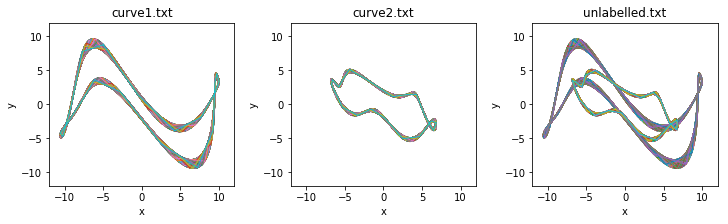

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (10,3)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = False

fig, ax = plt.subplots(1, 3, constrained_layout=True)

for k in range(0,len(data_c1),2):
    ax[0].plot(data_c1[k],data_c1[k+1])
    ax[1].plot(data_c2[k],data_c2[k+1])
    ax[2].plot(data_unlabelled[k],data_unlabelled[k+1])

for k in range(3):    
    ax[k].set_title(fileList[k])    
    ax[k].set_xlabel('x')
    ax[k].set_ylabel('y')
    ax[k].set_xlim(-12,12)
    ax[k].set_ylim(-12,12)

    
plt.show()

## Extract apparent features from the 2D trajectories.. 
1. Width of x and y, where the width measures the maximum distance along x and y axis. 
2. Total contour length, which is measured along the 2D contour
3. Mean curvature of a 2D curve 
4. Class assigned to be 1 or 2, representating curve 1 and 2, respectively

One can consider any other properties that may characterize the projected contour. 
In this example, I considered the three properties as described above. 

In [6]:
def get_width(d):
    width_x=[]
    width_y=[]
    for i in range(0,len(d),2):
        width_x.append(max(d[i])-min(d[i]))
        width_y.append(max(d[i+1])-min(d[i+1]))
    
    width_x = array(width_x)
    width_y = array(width_y)

    return width_x, width_y


def get_contourLength(d):
    contourLength=[]
    for i in range(0,len(d),2):
        contourLength.append(sum(sqrt(np.diff(d[i])**2 + np.diff(d[i+1])**2)))
    return contourLength


def get_meanCurvature(d):
    mcurv = []
    for i in range(0,len(d),2):
        x = d[i]
        y = d[i+1]

        dx = gradient(x)
        ddx = gradient(dx)
        dy = gradient(y)
        ddy = gradient(dy)
        num = dx * ddy - ddx * dy
        denom = dx * dx + dy * dy
        denom = sqrt(denom)
        denom = denom * denom * denom
        curvature = num / denom
        mcurv.append(mean(curvature)) 
    
    return mcurv

## Plot histograms of the measured properties

In this following box, the chosen properties are measured, and check how they look like in the histograms

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


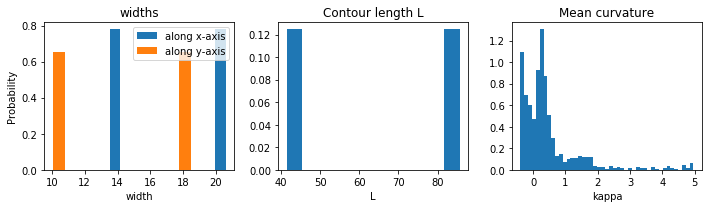

In [7]:
width_x_c1, width_y_c1 = get_width(data_c1)
width_x_c2, width_y_c2 = get_width(data_c2)

kappa_c1 = get_meanCurvature(data_c1)
kappa_c2 = get_meanCurvature(data_c2)

L_c1 = get_contourLength(data_c1)
L_c2 = get_contourLength(data_c2)


# get combined array for each property 
width_x = np.concatenate([width_x_c1, width_x_c2])
width_y = np.concatenate([width_y_c1, width_y_c2])
L_combined = np.concatenate([L_c1, L_c2])
kappa_combined = np.concatenate([kappa_c1, kappa_c2])


# plot histogram for combined properties 
fig, ax = plt.subplots(1, 3, tight_layout=True)

ax[0].hist(width_x,bins='auto',density=True, label='along x-axis')
ax[0].hist(width_y,bins='auto',density=True, label='along y-axis')
ax[0].legend()
ax[0].set_title('widths')
ax[0].set_xlabel('width')
ax[0].set_ylabel('Probability')

ax[1].hist(L_combined,bins='auto',density=True)
ax[1].set_title('Contour length L')
ax[1].set_xlabel('L')

ax[2].hist(kappa_combined,bins='auto',density=True)
ax[2].set_title('Mean curvature')
ax[2].set_xlabel('kappa')

plt.show()

# Three figures below show the distributions of the measured properties 

## Check correlations between curve index and the measured properties 


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


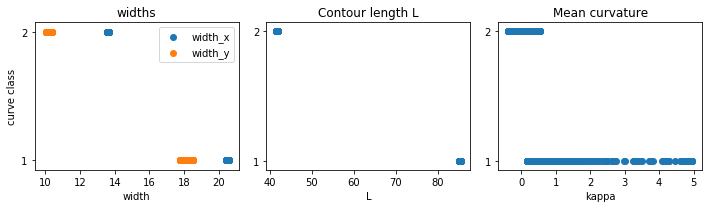

In [8]:
# get the curve index from two given data sets 
c1_index = ones(len(width_x_c1), dtype=int)
c2_index = ones(len(width_x_c1), dtype=int)*2
c_index = np.concatenate([c1_index, c2_index])


# check the relationship between curve index and extracted features 
# which helps us to choose the type of regression 
fig, ax = plt.subplots(1, 3, tight_layout=True)

ax[0].scatter(width_x, c_index, label='width_x')
ax[0].scatter(width_y, c_index, label='width_y')
ax[0].legend()
ax[0].set_title('widths')
ax[0].set_xlabel('width')
ax[0].set_ylabel('curve class')
ax[0].set_yticks([1,2])

ax[1].scatter(L_combined, c_index)
ax[1].set_title('Contour length L')
ax[1].set_xlabel('L')
ax[1].set_yticks([1,2])

ax[2].scatter(kappa_combined, c_index)
ax[2].set_title('Mean curvature')
ax[2].set_xlabel('kappa')
ax[2].set_yticks([1,2])

plt.show()

# As shown below, the measured features can be described by two-class model. 
# So, logistic regression is proper to apply, while linear regression is not applicable. 

# Note that while widths and contour length are well separated for two classes, 
# there is an overlap in the mean curvature 

## Contruct dataFrame containing the extracted features 

Now, let's apply the logistic regression to given data sets of curve 1 and 2.

First of all, the dataFrame is created, which contains all the measured properties as well as curve index.

In [9]:
data = {"class" : c_index,
        "width_x" : width_x, 
        "width_y" : width_y,
        "contour length" : L_combined,
        "mean curvature" : kappa_combined}

df = pd.DataFrame(data)

print(shape(df))
display(df.head())
display(df.tail())

(1000, 5)


,class,width_x,width_y,contour length,mean curvature
0,1,20.529963,18.497653,85.534764,1.953293
1,1,20.469602,18.306110,85.479455,0.597010
2,1,20.429298,18.158028,85.479001,0.271444
3,1,20.573866,18.421660,85.353572,0.246494
4,1,20.591026,17.770351,85.092498,0.353849


,class,width_x,width_y,contour length,mean curvature
995,2,13.581763,10.189390,41.639806,-0.011679
996,2,13.628088,10.210684,41.911976,-0.225135
997,2,13.644996,10.324538,41.962421,0.188347
998,2,13.623934,10.200392,41.461493,-0.265550
999,2,13.580249,10.194774,41.646009,-0.038312


## And then, train the model with given data sets 

In [10]:
# set input and output variables
x = df.loc[:,'width_x':'mean curvature']
y = df['class']

if len(x.shape)==1: # in case of training with a single property 
    x = x.values.reshape(-1,1)

# split the date into train and test sets     
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
        
    
# Try Ordinary Least Squares in order to print out summary 
x2 = sm.add_constant(x) 
model = sm.OLS(y,x2)
result = model.fit()
print(result.summary())

# try to predict 
y_pred = log_reg.predict(x_test)
print('accuracy :', metrics.accuracy_score(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:                  class   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.023e+07
Date:                Mon, 12 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:15:56   Log-Likelihood:                 4586.2
No. Observations:                1000   AIC:                            -9162.
Df Residuals:                     995   BIC:                            -9138.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.2627      0.009    355.

## Apply the trained model to given unlabelled data

Now, you can apply the model to unlabelled data for 500 curves. 


To this end, the same geometric features are measured from unlabelled curves, and a new dataFrame is created. 

And then, the trained model above is applied to the unlabelled curves with the same features 

In [11]:
# get the same features from the unlabelled curves 
width_x_ub, width_y_ub = get_width(data_unlabelled)
kappa_ub = get_meanCurvature(data_unlabelled)
L_ub = get_contourLength(data_unlabelled)

# construct dataFrame for logistic regression
data_ub = {"width_x" : width_x_ub, 
           "width_y" : width_y_ub,           
           "contour length" : L_ub,
           "mean curvature" : kappa_ub}

df_ub = pd.DataFrame(data_ub)

display(df_ub.head())
display(df_ub.tail())

,width_x,width_y,contour length,mean curvature
0,13.601527,10.378889,41.949680,0.555196
1,20.580466,18.371810,85.302617,0.200088
2,13.635783,10.182682,41.928220,-0.189200
3,13.541351,10.291673,41.778019,0.142154
4,13.591026,10.375191,41.935970,0.492092


,width_x,width_y,contour length,mean curvature
495,13.604913,10.076341,41.534279,-0.120215
496,13.618177,10.258906,41.558612,-0.312675
497,20.593047,17.822678,85.088502,0.289779
498,13.615702,10.377850,41.962333,0.522576
499,13.600725,10.281488,41.697092,-0.346171


In [12]:
x_ub = df_ub.loc[:,'width_x':'mean curvature']

if len(x_ub.shape)==1:  # in case of training with a single property 
    x_ub = x_ub.values.reshape(-1,1)
    
y_pred_ub = log_reg.predict(x_ub)

my_answer = y_pred_ub.tolist()

print('number of test curves:', len(my_answer))
print(my_answer)
myAnswerCorrect = my_answer
# this is my answer for the curve classificaiton of unlabelled curves 

number of test curves: 500
[2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 

# Appendix 
## Further check with a single property, mean curvature

The mean curvature displays a slight overlap between two classes of the projected curve. In this case, the accuracy of the prediction could decrease. 

The following two cells show the decreased accuracy for the prediction when the model is trained only by mean curvature. 

In [13]:
# Given labelled 2D curves 
x_ = df.loc[:,'mean curvature']
y_ = df['class']

if len(x_.shape)==1: # in case of training with a single property 
    x_ = x_.values.reshape(-1,1)

# split the date into train and test sets     
x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size=0.25)
log_reg_ = LogisticRegression()
log_reg_.fit(x_train_, y_train_)
        
    
# try to predict 
y_pred_ = log_reg_.predict(x_test_)
print('accuracy :', metrics.accuracy_score(y_test_, y_pred_))

accuracy : 0.748


In [14]:
# Given unlabelled 2D curves 
x_ub_ = df_ub.loc[:,'mean curvature']

if len(x_ub_.shape)==1:  # in case of training with a single property 
    x_ub_ = x_ub_.values.reshape(-1,1)
    
y_pred_ub_ = log_reg_.predict(x_ub_)

my_answer_ = y_pred_ub_.tolist()

print('accuracy :', metrics.accuracy_score(myAnswerCorrect, my_answer_))

accuracy : 0.774
